In [35]:
# Data wrangling
import pandas as pd 
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# Visualization
import matplotlib.pyplot as plt 
import matplotlib.ticker as tkr
import seaborn as sns 
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
# Date wrangling
import datetime as dt

# Math operations
import numpy as np

import tensorflow as tf

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [2]:
d = pd.read_csv('TaTrach1.csv')
print(f'Shape of data: {d.shape}')

Shape of data: (2248, 6)


In [3]:
# Types of columns
d.dtypes

date         object
TaTrach1    float64
TaTrach2    float64
TaTrach3    float64
TaTrach4    float64
Qden        float64
dtype: object

In [4]:
d['date'] = [pd.to_datetime(x) for x in d['date']]
d['date']

# Sắp xếp dữ liệu theo date
d.sort_values('date', inplace=True)
d.dtypes

date        datetime64[ns]
TaTrach1           float64
TaTrach2           float64
TaTrach3           float64
TaTrach4           float64
Qden               float64
dtype: object

In [5]:
# List ra thời gian đầu tiên và thời gian kết thúc 
print(f"Thời gian đầu tiên trong tập dữ liệu: {min(d['date'])}")
print(f"Thời gian cuối cùng trong tập dữ liệu: {max(d['date'])}")

Thời gian đầu tiên trong tập dữ liệu: 2020-08-29 17:00:00
Thời gian cuối cùng trong tập dữ liệu: 2020-12-01 08:00:00


In [6]:
print(f"Số lượng giờ có trong tập dữ liệu: {len(set(d['date']))}")

Số lượng giờ có trong tập dữ liệu: 2248


In [7]:
print(f"Số lượng dòng có trong tập dữ liệu: {d.shape[0]}")

Số lượng dòng có trong tập dữ liệu: 2248


In [8]:
# Features used in models
features = ['Qden','TaTrach1','TaTrach2','TaTrach3','TaTrach4']

# Aggregating to hourly level
#d = d.groupby('date', as_index=False)[features].mean()

# Creating the data column
d['datetime'] = [x.date() for x in d['date']]

In [9]:
d[features].describe()

,Qden,TaTrach1,TaTrach2,TaTrach3,TaTrach4
count,1997.0000,2248.0000,2248.0000,2248.0000,2248.0000
mean,297.1162,2.2524,2.2947,2.2524,2.0178
std,542.6812,7.2355,6.7316,7.2355,6.1045
min,0.3280,0.0000,0.0000,0.0000,0.0000
25%,0.4370,0.0000,0.0000,0.0000,0.0000
50%,141.8810,0.0000,0.0000,0.0000,0.0000
75%,319.0000,0.6000,0.8431,0.6000,0.5402
max,4024.0000,75.4000,64.9631,75.4000,59.3359


In [10]:
d['Qden'].fillna(0, inplace=True)

In [11]:
d[features].describe()

,Qden,TaTrach1,TaTrach2,TaTrach3,TaTrach4
count,2248.0000,2248.0000,2248.0000,2248.0000,2248.0000
mean,263.9418,2.2524,2.2947,2.2524,2.0178
std,519.9669,7.2355,6.7316,7.2355,6.1045
min,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3740,0.0000,0.0000,0.0000,0.0000
50%,102.0000,0.0000,0.0000,0.0000,0.0000
75%,293.0000,0.6000,0.8431,0.6000,0.5402
max,4024.0000,75.4000,64.9631,75.4000,59.3359


In [12]:
d[['date', 'Qden']].head(10)

,date,Qden
0,2020-08-29 17:00:00,100.8800
1,2020-08-29 18:00:00,115.9870
2,2020-08-29 19:00:00,381.6680
3,2020-08-29 20:00:00,371.6010
4,2020-08-29 21:00:00,368.0370
5,2020-08-29 22:00:00,371.0520
6,2020-08-29 23:00:00,357.5150
7,2020-08-30 00:00:00,0.4440
8,2020-08-30 01:00:00,399.8880
9,2020-08-30 02:00:00,393.3900


In [13]:
d[['date', 'Qden']].tail(10)

,date,Qden
2238,2020-11-30 23:00:00,282.2200
2239,2020-12-01 00:00:00,276.2520
2240,2020-12-01 01:00:00,317.6010
2241,2020-12-01 02:00:00,293.9990
2242,2020-12-01 03:00:00,329.4150
2243,2020-12-01 04:00:00,353.0570
2244,2020-12-01 05:00:00,329.4560
2245,2020-12-01 06:00:00,376.6820
2246,2020-12-01 07:00:00,376.7170
2247,2020-12-01 08:00:00,459.3830


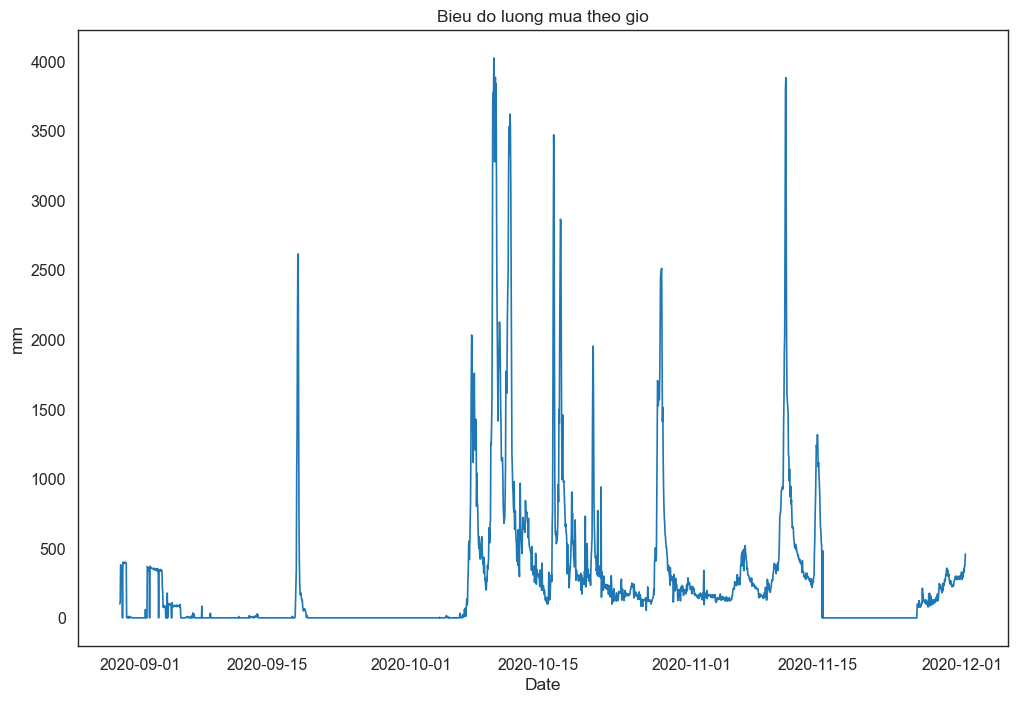

In [14]:
plt.figure(figsize=(12, 8))
plt.plot('date', 'Qden', data=d)
plt.title('Bieu do luong mua theo gio')
plt.ylabel('mm')
plt.xlabel('Date')
plt.show()

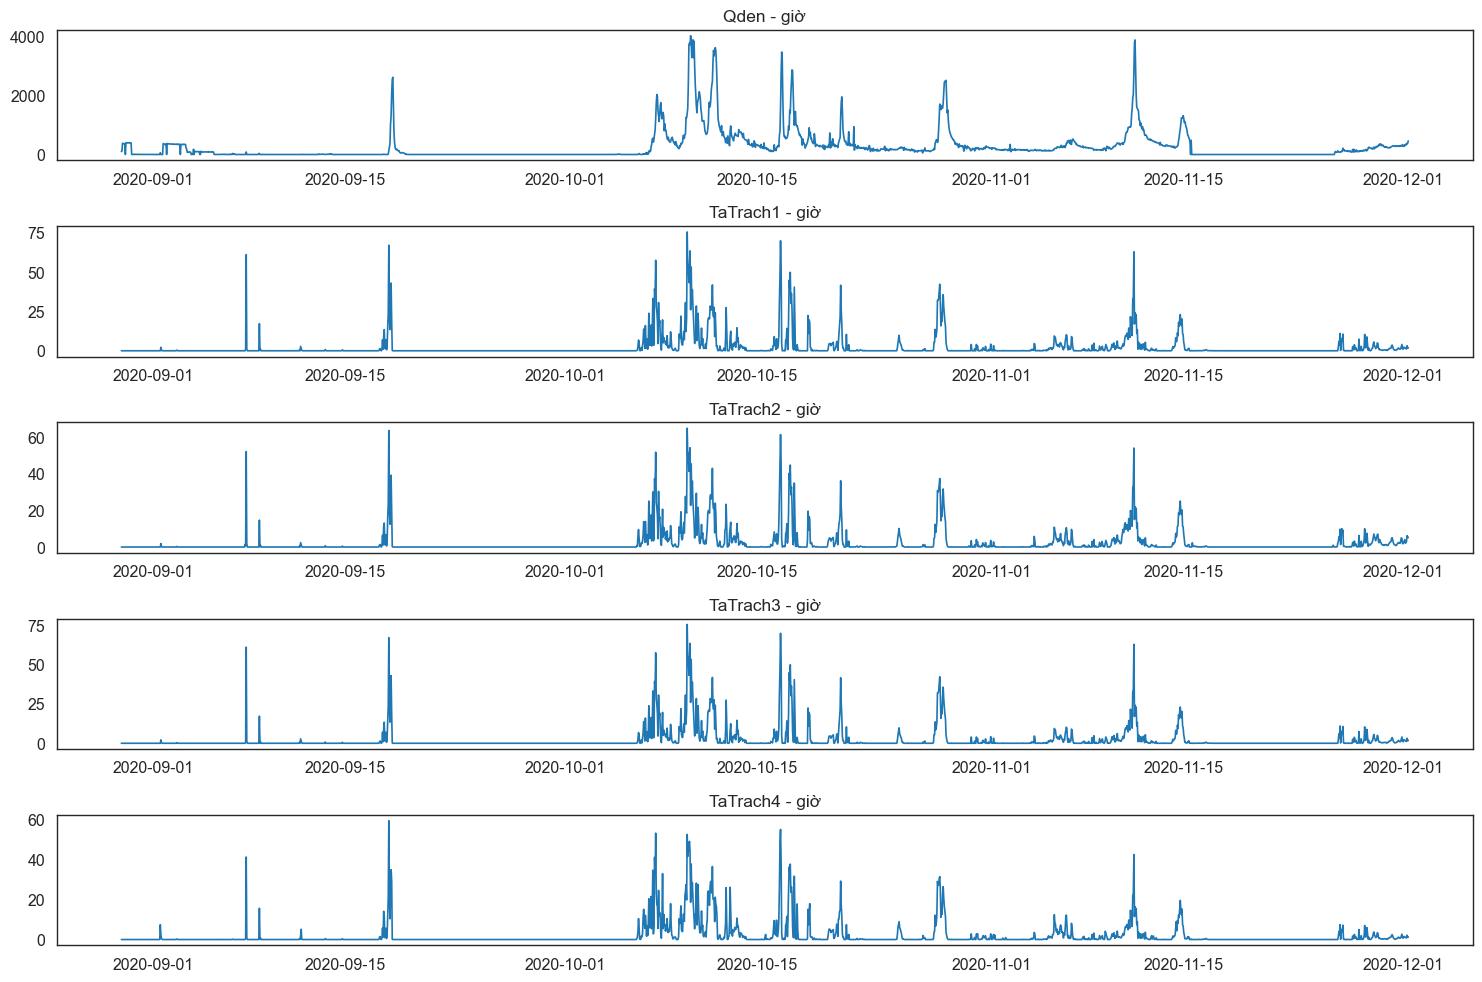

In [15]:
plot_features = d[features]
plot_features.index = d.date

fig, axes = plt.subplots(
    nrows=5, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['Qden','TaTrach1','TaTrach2','TaTrach3','TaTrach4']):
    axes[i % 5].plot(plot_features[feature])
    axes[i % 5].set_title(f'{feature} - giờ')
        
plt.tight_layout()

plt.show()

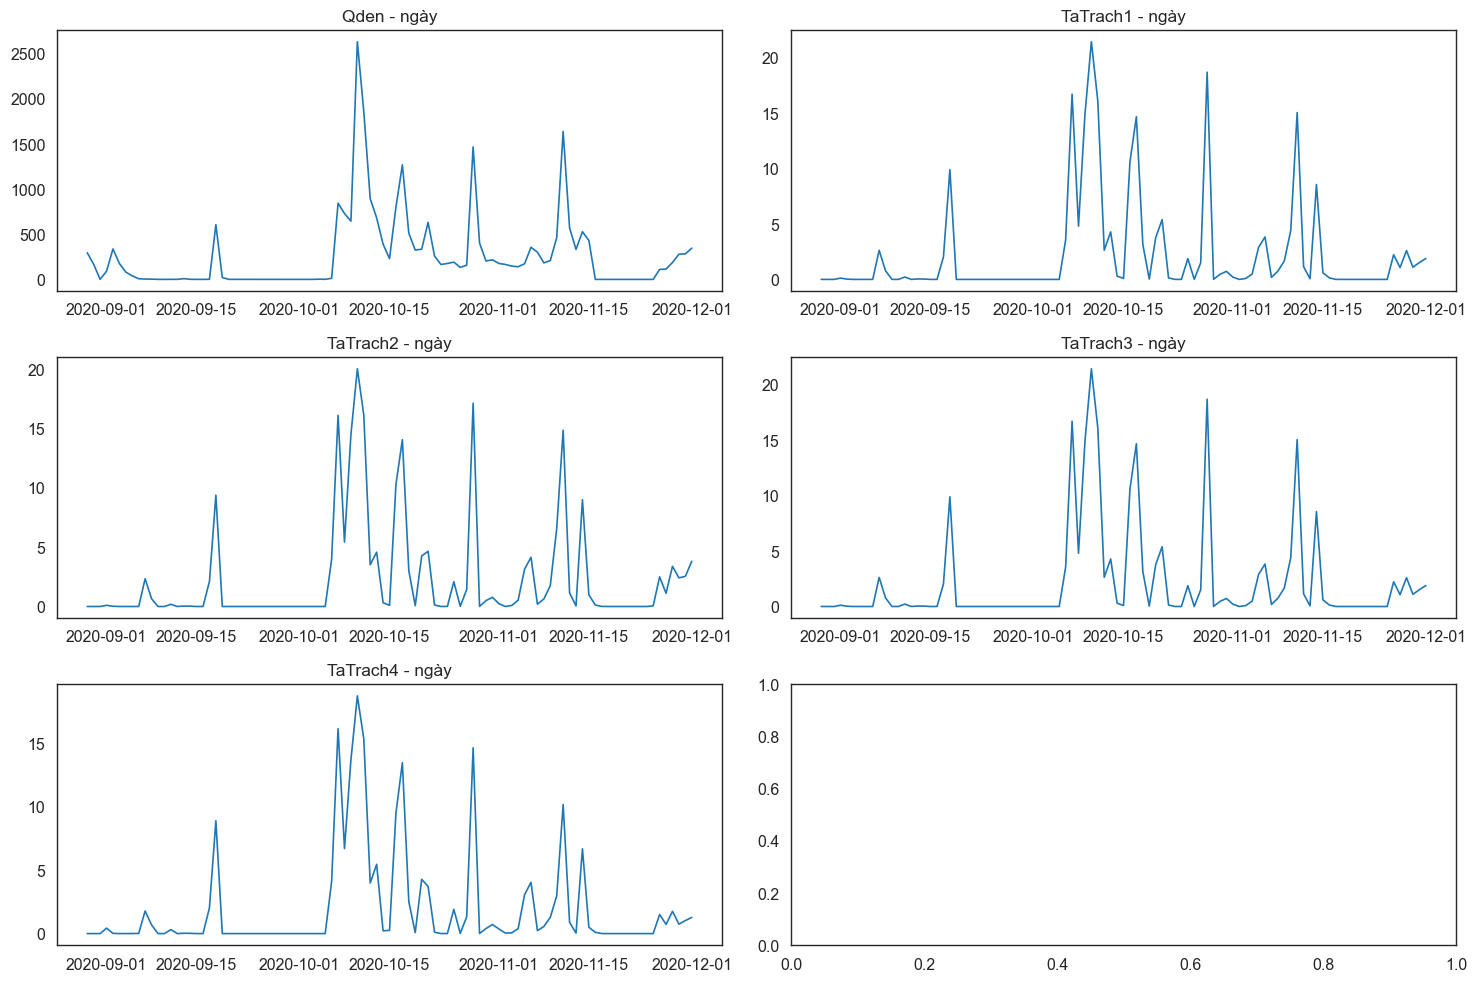

In [16]:
plot_features = d.groupby('datetime')[features].mean()

fig, axes = plt.subplots(
    nrows=3, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} - ngày')
        
plt.tight_layout()

plt.show()

In [17]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['date']]

# Extracting the month of the year 
d['month'] = [x.month for x in d['date']]

Text(0.5, 0, 'Lượng mưa tại hồ chứa Tả Trạch')

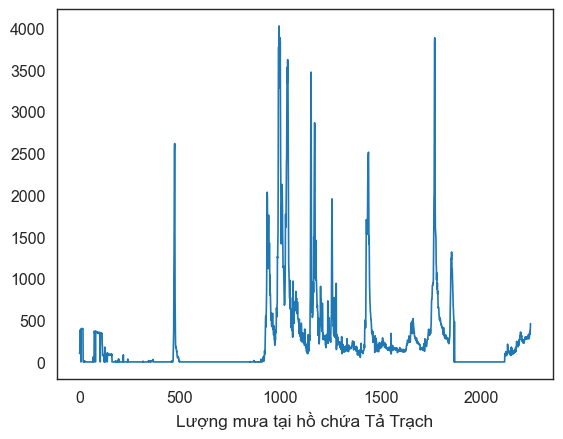

In [18]:
d['Qden'].plot()
plt.xlabel("Lượng mưa tại hồ chứa Tả Trạch")

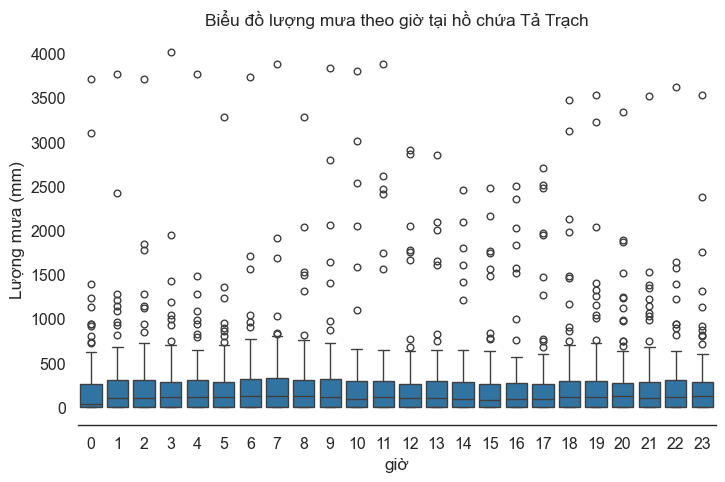

In [19]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
d['year'] = d['date'].apply(lambda x: x.year)

d['month'] = d['date'].apply(lambda x: x.month)
d['day'] = d['date'].apply(lambda x: x.day)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="hour", y="Qden", data=d)
plt.xlabel('giờ')
plt.ylabel('Lượng mưa (mm)')
plt.title('Biểu đồ lượng mưa theo giờ tại hồ chứa Tả Trạch')
sns.despine(left=True)
plt.tight_layout()



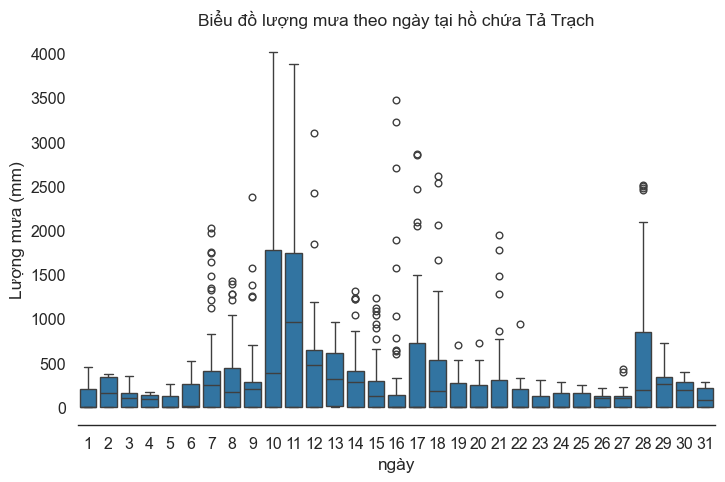

In [20]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="day", y="Qden", data=d)
plt.xlabel('ngày')
plt.ylabel('Lượng mưa (mm)')
plt.title('Biểu đồ lượng mưa theo ngày tại hồ chứa Tả Trạch')
sns.despine(left=True)
plt.tight_layout()



<Axes: xlabel='date'>

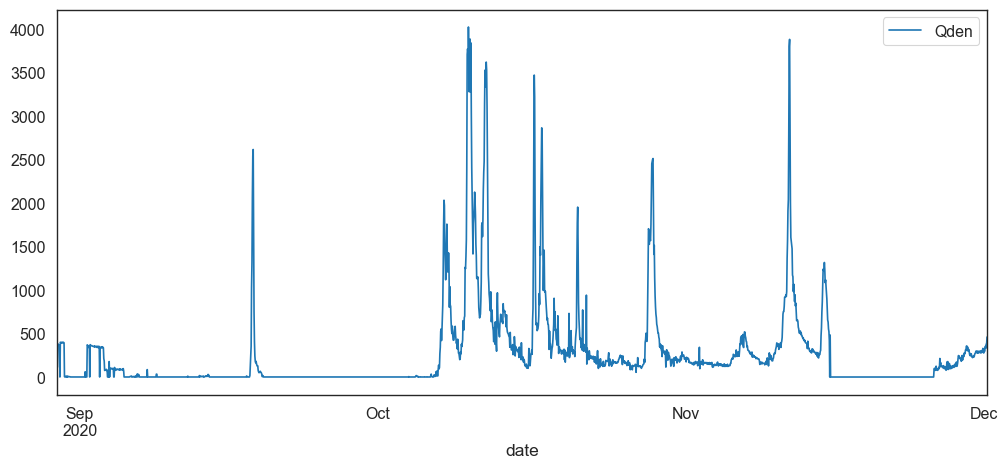

In [21]:
d1=d.loc[:,['date','Qden']]
d1.set_index('date',inplace=True)
d1.plot(figsize=(12,5))

,count,mean,std,min,25%,50%,75%,max
Qden,2248.0000,263.9418,519.9669,0.0000,0.3740,102.0000,293.0000,4024.0000


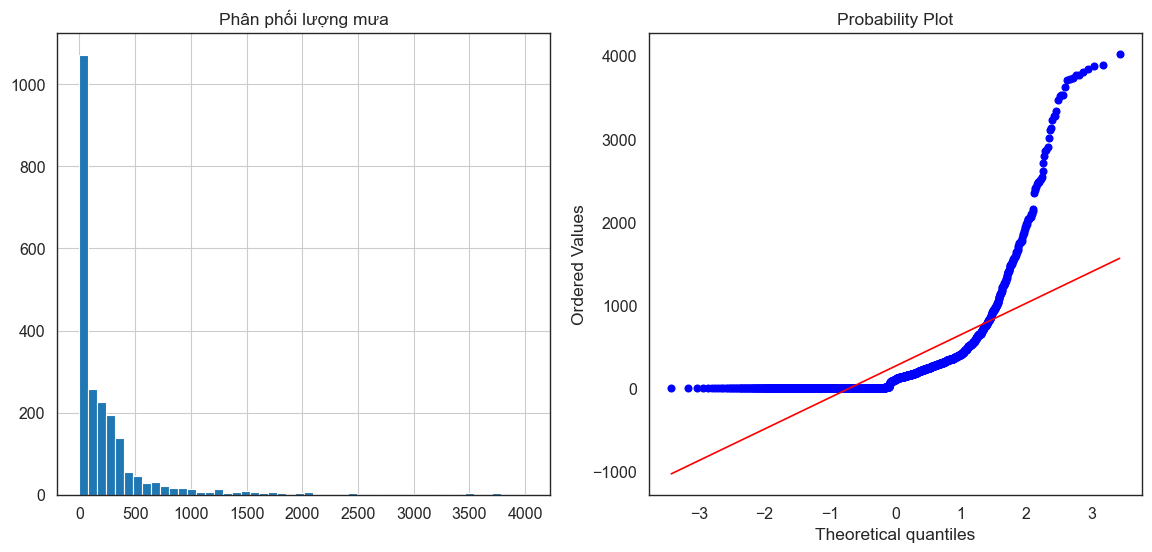

In [22]:
from scipy import stats
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
d['Qden'].hist(bins=50)
plt.title('Phân phối lượng mưa')
plt.subplot(1,2,2)
stats.probplot(d['Qden'], plot=plt);
d1.describe().T

# Trung bình lượng mưa theo giờ, ngày, tháng

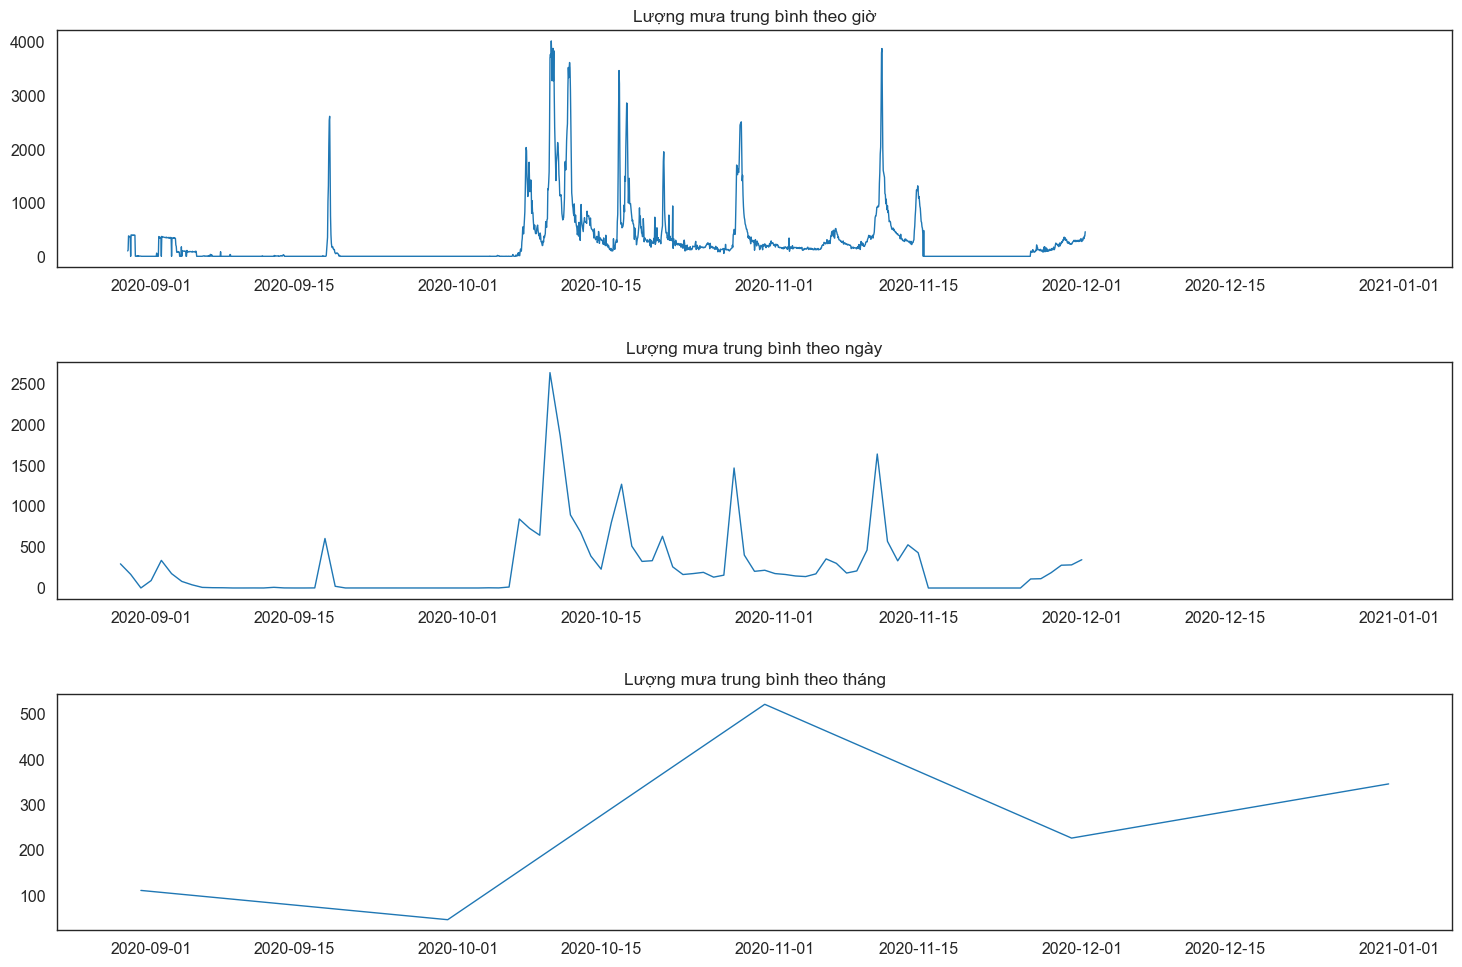

In [23]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

d['hour'] = d['date'].apply(lambda x: x.hour)

ax1  = fig.add_subplot(4,1,1)
ax1.plot(d1['Qden'].resample('H').mean(),linewidth=1)
ax1.set_title('Lượng mưa trung bình theo giờ')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(4,1,2, sharex=ax1)
ax2.plot(d1['Qden'].resample('D').mean(),linewidth=1)
ax2.set_title('Lượng mưa trung bình theo ngày')
ax2.tick_params(axis='both', which='major')


ax3 = fig.add_subplot(4,1,3, sharex=ax1)
ax3.plot(d1['Qden'].resample('M').mean(),linewidth=1)
ax3.set_title('Lượng mưa trung bình theo tháng')
ax3.tick_params(axis='both', which='major')


Text(0.5, 1.0, 'Trung bình lượng mưa theo từng tháng trong năm')

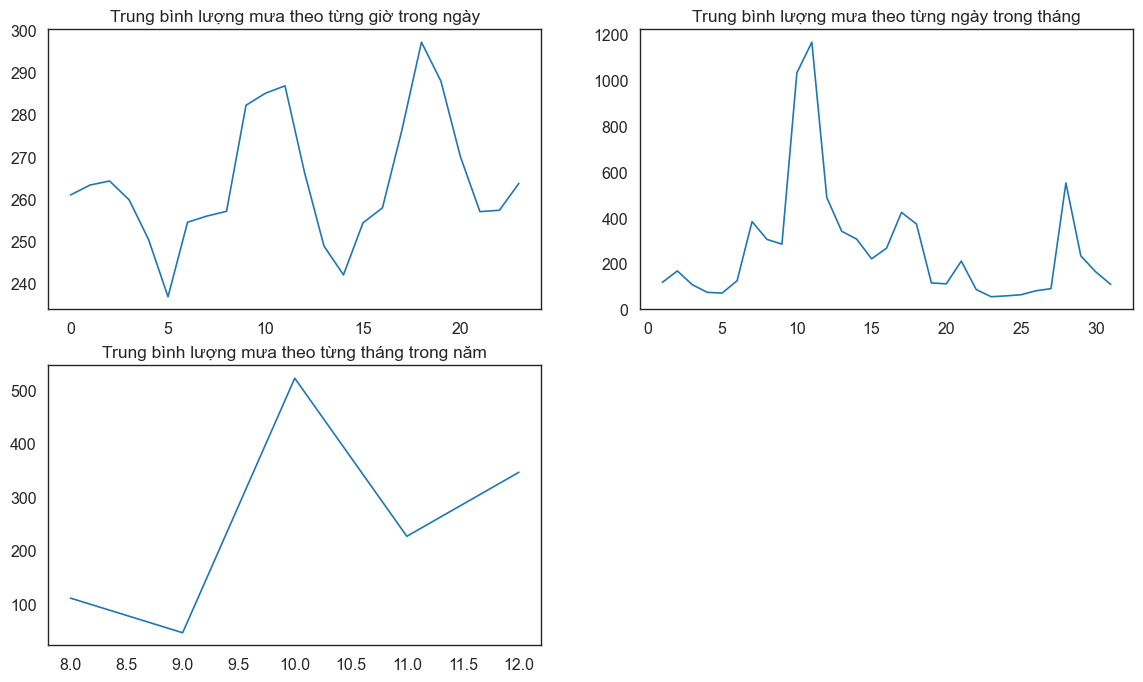

In [24]:
plt.figure(figsize=(14,8))

#Vẽ đồ thị với tổng hợp các giá trị mean theo từng giờ
plt.subplot(2,2,1)
d.groupby('hour').Qden.agg('mean').plot()
plt.xlabel('')
plt.title('Trung bình lượng mưa theo từng giờ trong ngày')

#Vẽ đồ thị với tổng hợp các giá trị mean theo từng giờ
plt.subplot(2,2,2)
d.groupby('day').Qden.agg('mean').plot()
plt.xlabel('')
plt.title('Trung bình lượng mưa theo từng ngày trong tháng')

plt.subplot(2,2,3)
d.groupby('month').Qden.agg('mean').plot()
plt.xlabel('')
plt.title('Trung bình lượng mưa theo từng tháng trong năm')


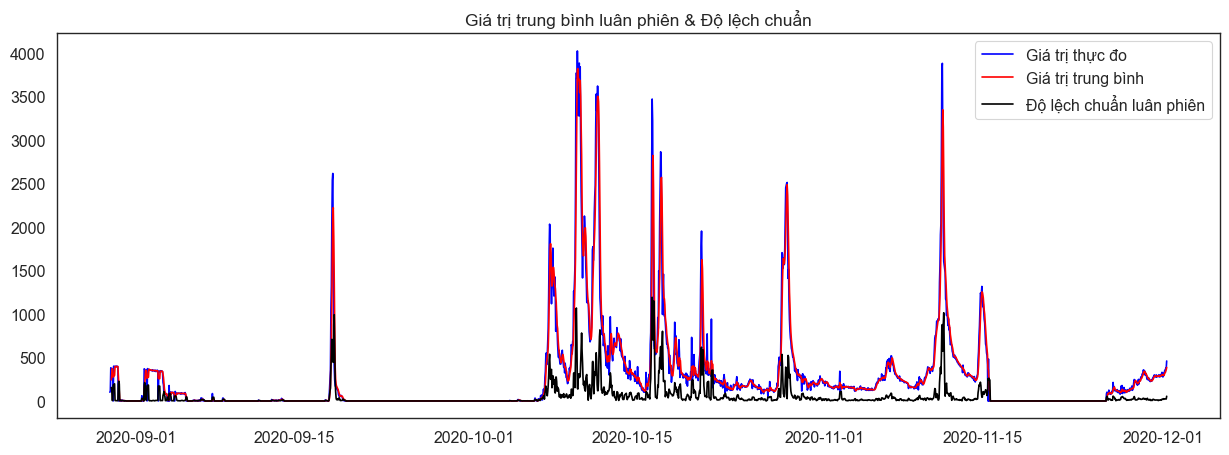

<Kết quả của Kiểm Định Dickey - Fuller>
Test statistic                   -5.2976
p-value                           0.0000
#Lags Used                       22.0000
Số lần quan sát được sử dụng   2225.0000
Critical Value (1%)              -3.4333
Critical Value (5%)              -2.8628
Critical Value (10%)             -2.5675
dtype: float64


In [25]:
#d2=d1.resample('D', how=np.mean)
d2 = d1.resample('H').agg(np.mean)
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()
    
    plt.figure(figsize=(15,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Giá trị thực đo')
    mean = plt.plot(rolmean, color='red', label='Giá trị trung bình')
    std = plt.plot(rolstd, color='black', label = 'Độ lệch chuẩn luân phiên')

    plt.legend(loc='best'); plt.title('Giá trị trung bình luân phiên & Độ lệch chuẩn')
    plt.show()
    
    #Dùng adfuller test để kiểm tra tính ổn định của chuỗi
    from statsmodels.tsa.stattools import adfuller
    
    print ('<Kết quả của Kiểm Định Dickey - Fuller>')
    dtest = adfuller(timeseries, autolag='AIC')
    doutput = pd.Series(dtest[0:4],
                         index=['Test statistic','p-value','#Lags Used','Số lần quan sát được sử dụng'])
    for key,value in dtest[4].items():
        doutput['Critical Value (%s)'%key] = value
        
    print(doutput)
test_stationarity(d2.Qden.dropna())

In [26]:
#gán giá trị của Qden vào mảng dataset
dataset = d.Qden.values #numpy.ndarray
dataset = dataset.astype('float32')
#Chuyển dataset thành mảng 1 chiều gồm n hàng 1 cột
dataset = np.reshape(dataset, (-1, 1))

#Tính toán và chuyển giá trị của dữ liệu trong dataset nằm trong khoảng từ 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Tập train gồm 67% tập dữ liệu (1506), tập test gồm 20% tập dữ liệu (742)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

#Tạo mảng train với dữ liệu từ hàng 1-1506, ma trận test với dữ liệu từ hàng 1507-2248.
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

#Hàm convert giá trị trong mảng thành dạng ma trận với các giá trị t-4, t-2, t-3, t-1, t
def create_dataset(dataset, look_back=4):
    X, Y = [], []
    for i in range(len(dataset)-look_back-4):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 4
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [27]:
model = Sequential()

model.add(SimpleRNN(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(10))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=120, batch_size=256, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()



Epoch 1/120

6/6 [==============================] - 4s 135ms/step - loss: 0.0274 - val_loss: 0.0103
Epoch 2/120
6/6 [==============================] - 0s 30ms/step - loss: 0.0224 - val_loss: 0.0081
Epoch 3/120
6/6 [==============================] - 0s 27ms/step - loss: 0.0184 - val_loss: 0.0064
Epoch 4/120
6/6 [==============================] - 0s 30ms/step - loss: 0.0152 - val_loss: 0.0053
Epoch 5/120
6/6 [==============================] - 0s 22ms/step - loss: 0.0128 - val_loss: 0.0045
Epoch 6/120
6/6 [==============================] - 0s 19ms/step - loss: 0.0111 - val_loss: 0.0040
Epoch 7/120
6/6 [==============================] - 0s 20ms/step - loss: 0.0097 - val_loss: 0.0036
Epoch 8/120
6/6 [==============================] - 0s 21ms/step - loss: 0.0085 - val_loss: 0.0032
Epoch 9/120
6/6 [==============================] - 0s 19ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 10/120
6/6 [==============================] - 0s 26ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 11/120
6/

In [28]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train MAE:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train MSE:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])*mean_squared_error(Y_train[0], train_predict[:,0])))
print('Train RMSE:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test MAE:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test MSE:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])*mean_squared_error(Y_test[0], test_predict[:,0])))
print('Test RMSE:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


23/23 [==============================] - 0s 4ms/step
Train MAE: 57.40974808664555
Train MSE: 18296.692387158942
Train RMSE: 135.26526674338444
Test MAE: 32.191852559608975
Test MSE: 6362.077529076943
Test RMSE: 79.76263241065294


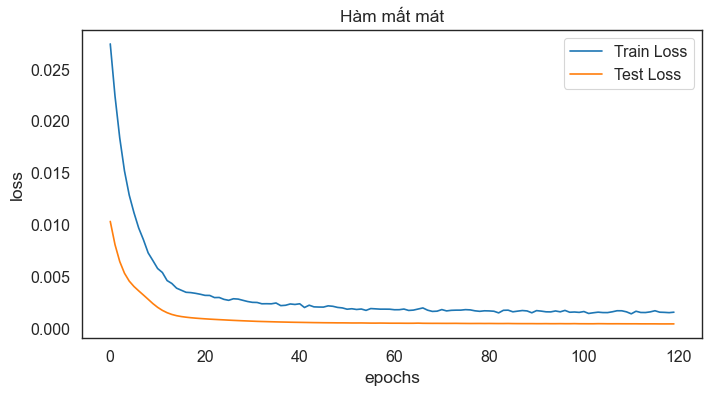

In [29]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Hàm mất mát')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

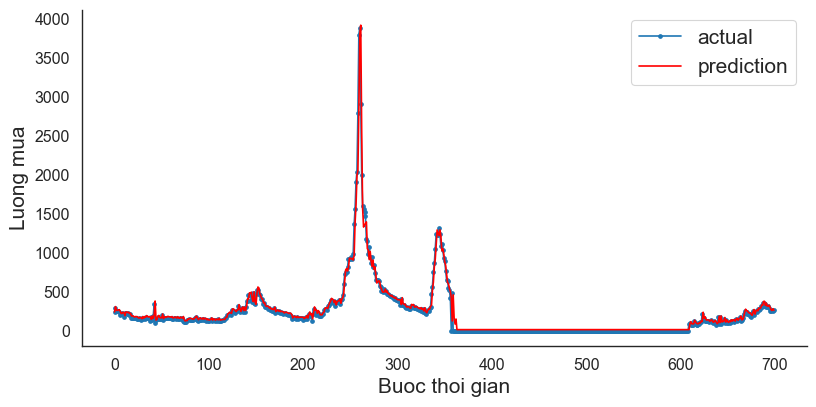

In [30]:
aa=[x for x in range(700)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][0:700], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:700], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Luong mua', size=15)
plt.xlabel('Buoc thoi gian', size=15)
plt.legend(fontsize=15)
plt.show();

In [31]:
print(Y_test.shape)

(1, 734)


In [32]:
print(test_predict.shape)

(734, 10)


In [33]:
#test_predict = np.reshape(test_predict, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

In [34]:
absHieu = np.abs(test_predict-Y_test)
df3 = pd.DataFrame(absHieu,columns=['ABS Hieu'])
powHieu = np.power(test_predict-Y_test, 2)
df4 = pd.DataFrame(absHieu,columns=['pow Hieu'])
df1 = pd.DataFrame(test_predict,columns=['Du doan'])
df2 = pd.DataFrame(Y_test,columns=['Thuc do'])

df = df2.join(df1).join(df3).join(df4)
df.insert(4, "", "") 
df.insert(5, "", "") 
result = pd.DataFrame(df)
result.to_csv('prediction.csv') 

ValueError: Shape of passed values is (734, 10), indices imply (734, 1)

In [ ]:
MAE1 = np.sum(absHieu)/734
df5 = pd.DataFrame(MAE1,columns=['MAE'])
MSE1 = np.sum(powHieu)/734
df6 = pd.DataFrame(MSE1,columns=['MSE'])
RMSE1 = np.sqrt(MSE1)
df7 = pd.DataFrame(RMSE1,columns=['RMSE'])
df = df.join(df5).join(df6).join(df7)